ESTO ES PARA EL CST

In [177]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import os
import meshio
import math
import sys
from matplotlib.patches import Polygon
from matplotlib.tri import Triangulation
from CST import CST
from Node import Node
from solve import Solve
from functions import matrix_extract,  get_nodes_from_physical_id, get_line_load_global_vector, matrix_replace


In [178]:
input_file = "T4.geo"
output_file = "mallas/malla_CST.msh"  
titulo = "Caso CST"

In [179]:
mesh = meshio.read(output_file)
    # Crear nodos
nodes = [Node(i+1, x, y) for i, (x, y, _) in enumerate(mesh.points)]

    # Crear elementos CST
cst_elements = []
for cell_block in mesh.cells:
    if cell_block.type == "triangle":
        for i, node_ids in enumerate(cell_block.data):
            node_ids = [int(id) + 1 for id in node_ids]  # Convertir a índices base 1
                
            cst_elements.append(CST(i+1 , list(node_ids)))
        break
boundary_nodes = {1: set(), 2: set(), 3: set(), 4: set()}

for i, cell_block in enumerate(mesh.cells):
    if cell_block.type == "line":
            physical_ids = mesh.cell_data_dict['gmsh:physical']['line']
            for line, phys_id in zip(cell_block.data, physical_ids):
                if phys_id in boundary_nodes:
                    for node_id in line:
                        boundary_nodes[phys_id].add(int(node_id))

    # Añadir etiquetas de borde a los nodos
for node in nodes:
        node.boundary_label = []
        for label_id, node_set in boundary_nodes.items():
            if node.id in node_set:
                node.boundary_label.append(f"Diritchlet Boundary")

In [180]:

#Ahora debo calcular la solucion u
alpha = 6

for node in nodes:
    node.solve_u(alpha)

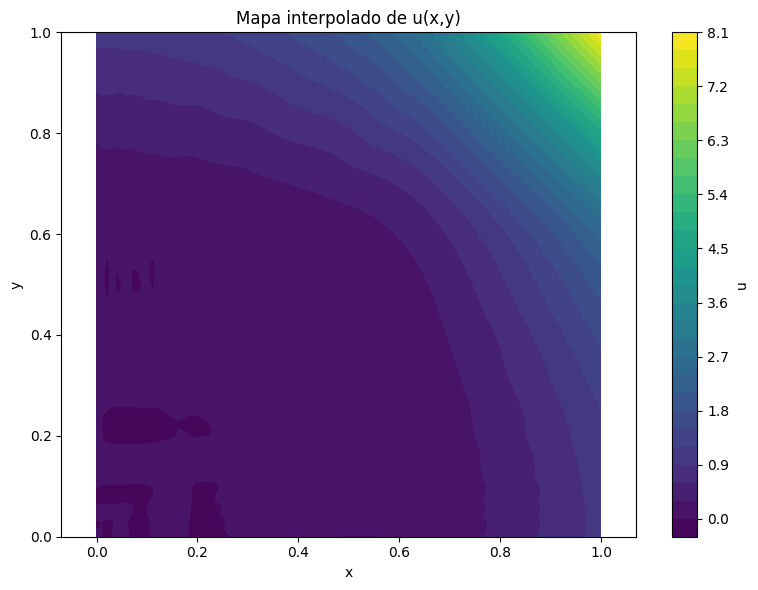

In [181]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.tri import Triangulation
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

def plot_u_field(nodes, elements, use_attr="u", mode="colormap"):
    """
    Visualiza el campo u(x,y) o u_fem(x,y) usando distintos modos:
    - 'colormap'  → mapa de color interpolado (2D)
    """
    # Extraer coordenadas y valores de campo
    x = np.array([node.x for node in nodes])
    y = np.array([node.y for node in nodes])
    z = np.array([getattr(node, use_attr) for node in nodes])

    # Conectividad de elementos (base 1 → base 0)
    triangles = np.array([[nid - 1 for nid in elem.node_ids] for elem in elements])
    tri = Triangulation(x, y, triangles)

    if mode == "colormap":
        # Crear malla regular
        xi = np.linspace(min(x), max(x), 100)
        yi = np.linspace(min(y), max(y), 100)
        X, Y = np.meshgrid(xi, yi)

        # Interpolación desde nodos hacia malla
        Z = griddata((x, y), z, (X, Y), method='cubic')

        # Graficar mapa de colores
        plt.figure(figsize=(8, 6))
        plt.contourf(X, Y, Z, levels=30, cmap='viridis')
        plt.colorbar(label=use_attr)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(f"Mapa interpolado de {use_attr}(x,y)")
        plt.axis("equal")
        plt.tight_layout()
        plt.savefig(f"CST_{use_attr}_{mode}_plot.png", dpi=300)
        plt.show()

    else:
        raise ValueError("Modo no válido. Usa solo 'colormap' en esta versión.")

# Uso: solución exacta u
plot_u_field(nodes, elements, use_attr="u", mode="colormap")


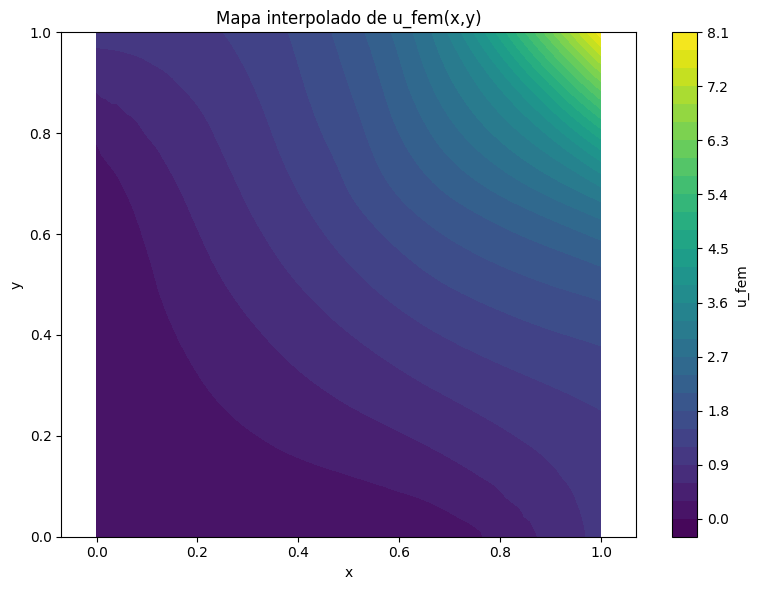

In [182]:
Estructure = Solve(nodes, elements, alpha)
Estructure.solve_matrix()

# Uso: solución FEM u_fem
plot_u_field(nodes, elements, use_attr="u_fem", mode="colormap")

In [183]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.tri import Triangulation
from scipy.interpolate import griddata

def plot_relative_error(nodes, elements, mode="colormap"):
    """
    Visualiza el error relativo |u_fem - u| / |u| mediante:
    - 'colormap' → mapa de color interpolado en 2D
    """
    # Extraer datos de nodos
    x = np.array([node.x for node in nodes])
    y = np.array([node.y for node in nodes])
    u_num = np.array([node.u_fem for node in nodes])
    u_ref = np.array([node.u for node in nodes])

    # Evitar división por cero
    eps = 1e-14
    error_rel = np.abs(u_num - u_ref) / (np.abs(u_ref) + eps)

    # Conectividad de elementos
    triangles = np.array([[nid - 1 for nid in elem.node_ids] for elem in elements])
    tri = Triangulation(x, y, triangles)

    if mode == "colormap":
        # Interpolación sobre malla regular
        xi = np.linspace(min(x), max(x), 100)
        yi = np.linspace(min(y), max(y), 100)
        X, Y = np.meshgrid(xi, yi)
        Z = griddata((x, y), error_rel, (X, Y), method='cubic')

        plt.figure(figsize=(8, 6))
        plt.contourf(X, Y, Z, levels=30, cmap='plasma')
        plt.colorbar(label="Error relativo")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Error relativo |u_fem - u| / |u|")
        plt.axis("equal")
        plt.tight_layout()
        plt.savefig("CST_relative_error_colormap.png", dpi=300)
        plt.show()

    else:
        raise ValueError("Modo no válido. Usa 'colormap'.")

    # Imprimir resumen numérico
    print(f"Máximo error relativo: {np.max(error_rel):.2e}")
    print(f"Promedio error relativo: {np.mean(error_rel):.2e}")
    print(f"Mínimo error relativo: {np.min(error_rel):.2e}")

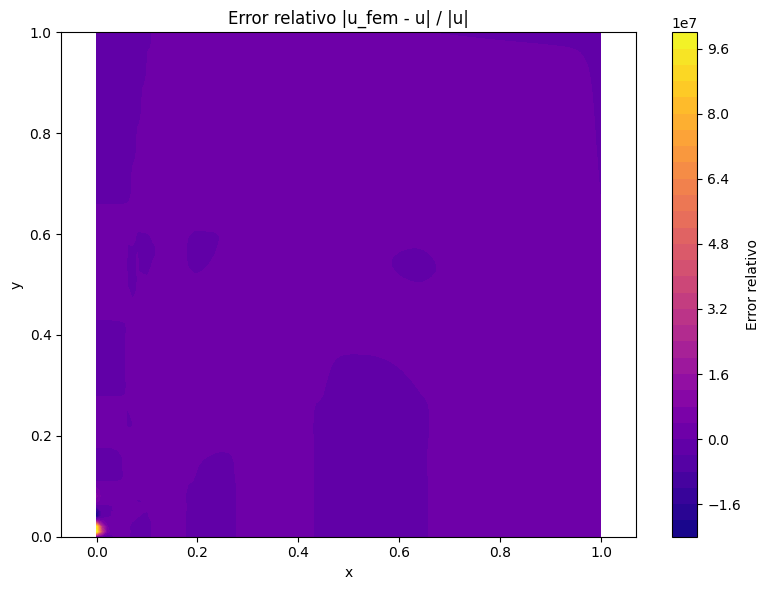

Máximo error relativo: 1.11e+08
Promedio error relativo: 1.37e+06
Mínimo error relativo: 0.00e+00


In [184]:
# Visualizar el error relativo
plot_relative_error(nodes, elements, mode="colormap")